<a href="https://colab.research.google.com/github/kevintsi/deep_learning_course/blob/main/Deep_learning_course_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Production

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 43.8 MB/s 
     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 189 kB 54.3 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 223 kB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'd69e5d38a5a640e0b867277ae3c5edc9')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

Recherche 'grizzly bear' sur Bing et récupères les résultats en ne prenant que l'attribut 'contentUrl'

In [6]:
results = search_images_bing(key, 'grizzly bear') 
ims = results.attrgot('contentUrl')
len(ims)

150

Télécharge une image et l'ajoute au dossier images avec comme nom de fichier (grizzly.jpg)

In [7]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [8]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

Affiche l'image qui a été téléchargé sous forme de miniature

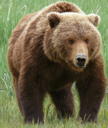

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

Si le dossier 'bears' n'existe pas il est crée puis pour chaque type d'ours (liste bear_types)
un dossier est crée à son nom puis une liste d'image est téléchargé avec les résultats obtenu suite
à la recherche

In [11]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

Récupère la liste des images téléchargées dans le path donnée

In [12]:
fns = get_image_files(path)
fns

(#439) [Path('bears/black/00000054.jpg'),Path('bears/black/00000092.jpg'),Path('bears/black/00000067.jpg'),Path('bears/black/00000028.jpg'),Path('bears/black/00000034.jpg'),Path('bears/black/00000038.jpg'),Path('bears/black/00000011.jpg'),Path('bears/black/00000073.jpg'),Path('bears/black/00000096.jpg'),Path('bears/black/00000045.png')...]

Donne la liste des images qui ne peuvent pas être ouverte

In [13]:
failed = verify_images(fns)
failed

(#2) [Path('bears/teddy/00000084.png'),Path('bears/teddy/00000094.jpg')]

In [14]:
failed.map(Path.unlink);

DataBlock

In [15]:
doc(DataBlock)

In [16]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

blocks=(IndependentVariable, DependentVariable)

  IndependentVariable : Categories<br/>
  DependentVariable : Target

In [17]:
dls = bears.dataloaders(path)

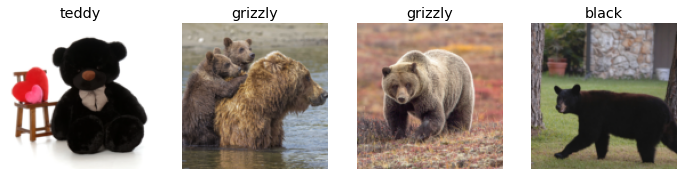

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

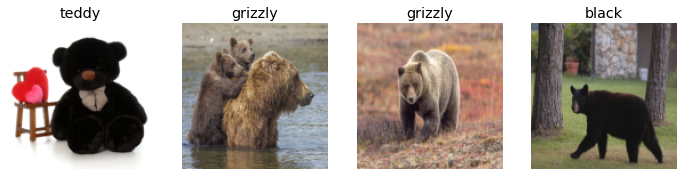

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

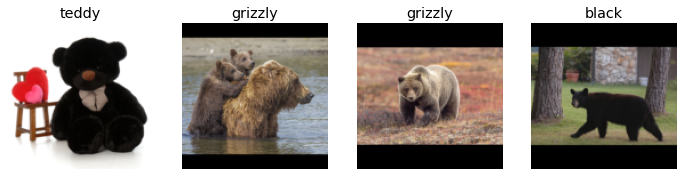

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

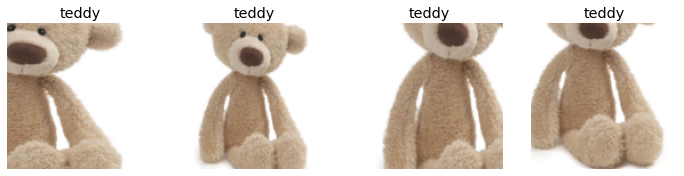

In [21]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


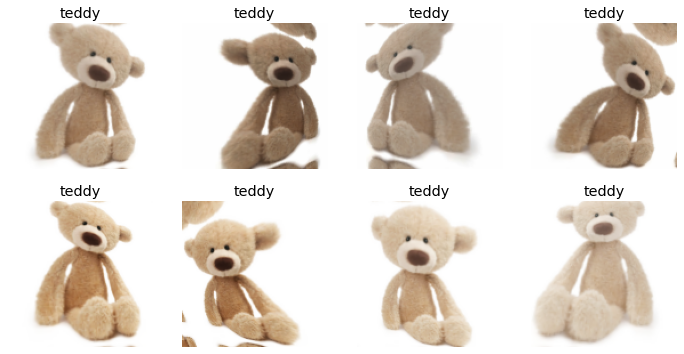

In [22]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [23]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [24]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.670284,0.183385,0.080460,01:31


epoch,train_loss,valid_loss,error_rate,time
0,0.188231,0.052053,0.022989,02:02
1,0.119060,0.018985,0.000000,01:57
2,0.080341,0.011570,0.000000,02:02
3,0.070642,0.012677,0.011494,01:59


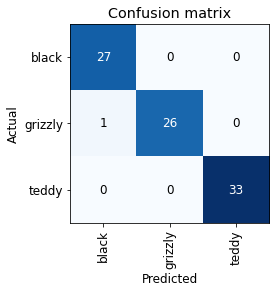

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

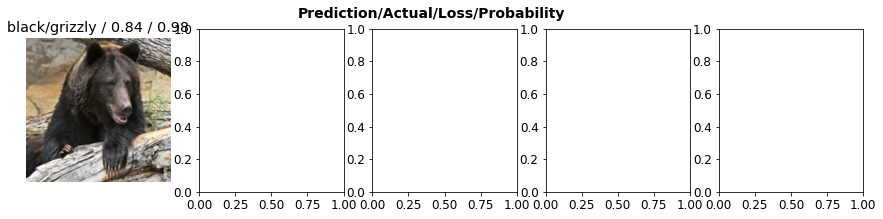

In [28]:
interp.plot_top_losses(5, nrows=1)

In [29]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [30]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [31]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Export du modèle

In [32]:
learn.export()

In [33]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [34]:
learn_inf = load_learner(path/'export.pkl')

In [35]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([7.2779e-06, 9.9999e-01, 5.7061e-07]))

In [36]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [37]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [39]:
img = PILImage.create(btn_upload.data[-1])

In [40]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [41]:
pred,pred_idx,probs = learn_inf.predict(img)

In [42]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9996')

In [43]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [44]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [45]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [46]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Obtenir une vrai application

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 